In [10]:
import os
import re
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.table import vstack, hstack
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
def get_raj_decj_data(filepath: str):
    """Returns the RA and DEC data from a given FITS file"""
    table = Table.read(filepath, hdu=2)
    return hstack([table["RAJ2000"], table["DECJ2000"]])


def print_values(filepath: str):
    """Simply prints the highest and lowest RA/DEC values from a FITS file"""
    table = get_raj_decj_data(filepath)
    ra = table["RAJ2000"]
    dec = table["DECJ2000"]
    print(
        "The lowest and highest values of the RAJ2000 data are"
        f" {ra.min()} and {ra.max()}. The lowest and highest values"
        f" of the DECJ2000 data are {dec.min()} and {dec.max()}."
    )


def plot_one_file(filepath: str):
    """Generates scatterplot of RA vs. DEC data for one file"""
    data = get_raj_decj_data(filepath)
    plt.scatter(data["DECJ2000"], data["RAJ2000"])
    plt.title("RAJ2000 vs. DECJ2000")
    plt.xlabel("deg")
    plt.ylabel("deg")
    plt.show()


def stack_tables(directory: str):
    """Returns combined tables of RA and DEC data for all files in a directory"""
    stacked_tables = []
    for filename in Path(directory).glob("*"):
        table = get_raj_decj_data(filename)
        stacked_tables.append(table)
    return vstack(stacked_tables)


def expanded_stack_tables(rootdir: str):
    """Combines RA, DEC data for files in subdirectories within a directory"""
    stacked_tables = []
    paths = list(Path(rootdir).glob("*/Antenna/*.fits"))
    for path in tqdm(paths):
        print(f"Loading {path}")
        table = get_raj_decj_data(path)
        stacked_tables.append(table)
    return vstack(stacked_tables)


def separated_stack_tables_dict(rootdir: str):
    """Returns a dictionary of RA, DEC data corresponding to different projects"""
    tables = {}
    for subdir in tqdm(os.listdir(rootdir)):
        project_match = re.match(r"[a-zA-Z0-9]+[_][\d]+[_]", str(subdir))
        if not project_match:
            raise ValueError("File does not match naming format")
        else:
            project = project_match.group(0)[:-1]
        # split = subdir.split("_")
        # project = "_".join(split[:-1])
        paths = list(Path(os.path.join(rootdir, subdir)).glob("Antenna/*.fits"))
        for path in paths:
            table = get_raj_decj_data(path)
            if project not in list(tables):
                tables[project] = [table]
            else:
                tables[project].append(table)
        print(list(tables))
    for project in tables:
        tables[project] = vstack(tables[project])
    return tables


def separated_stack_tables_table(rootdir: str):
    """Returns a table of RA, DEC, project name data"""
    stacked_table = []
    projects = []
    for subdir in tqdm(os.listdir(rootdir)):
        split = subdir.split("_")
        project = "_".join(split[:-1])
        paths = list(Path(os.path.join(rootdir, subdir)).glob("Antenna/*.fits"))
        for path in paths:
            table = Table.read(path, hdu=2)
            formatted_table = hstack(
                [
                    table["RAJ2000"],
                    table["DECJ2000"],
                    Column(name="Project", data=np.full(len(table), project)),
                ]
            )
            stacked_table.append(formatted_table)
            if project not in projects:
                projects.append(project)
    return vstack(stacked_table), projects


def plot_all_files(directory: str):
    """Generates scatterplot of RA vs. DEC data for all files in a directory"""
    table = stack_tables(directory)
    plt.scatter(table["DECJ2000"], table["RAJ2000"], s=0.5)
    plt.xlabel("deg")
    plt.ylabel("deg")
    plt.show()


def projection(directory: str):
    """Plots a Mollweide projection for stacked data in a directory"""
    table = stack_tables(directory)
    ra = coord.Angle(table["RAJ2000"])
    ra = ra.wrap_at(180 * u.degree)
    dec = coord.Angle(table["DECJ2000"])
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.scatter(ra.radian, dec.radian, s=0.5)
    ax.set_xticklabels(
        ["14h", "16h", "18h", "20h", "22h", "0h", "2h", "4h", "6h", "8h", "10h"]
    )
    ax.grid(True)
    fig.show()


def expanded_projection(directory: str):
    """Plots a Mollweide projection for stacked data in a directory"""
    table = expanded_stack_tables(directory)
    ra = coord.Angle(table["RAJ2000"])
    ra = ra.wrap_at(180 * u.degree)
    dec = coord.Angle(table["DECJ2000"])
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    ax.scatter(ra.radian, dec.radian, s=0.5)
    ax.set_xticklabels(
        ["14h", "16h", "18h", "20h", "22h", "0h", "2h", "4h", "6h", "8h", "10h"]
    )
    ax.grid(True)
    fig.show()


def colored_projection_dict(directory: str):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    tables = separated_stack_tables_dict(directory)
    for project in tables:
        ra = coord.Angle(tables[project]["RAJ2000"])
        ra = ra.wrap_at(180 * u.degree)
        dec = coord.Angle(tables[project]["DECJ2000"])
        ax.scatter(ra.radian, dec.radian, s=0.5)
    ax.set_xticklabels(
        ["14h", "16h", "18h", "20h", "22h", "0h", "2h", "4h", "6h", "8h", "10h"]
    )
    ax.grid(True)
    fig.show()


def colored_projection_table(directory: str):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    table, projects = separated_stack_tables_table(directory)
    for project in projects:
        sliced = table[table["Project"] == project]
        ra = coord.Angle(sliced["RAJ2000"])
        ra = ra.wrap_at(180 * u.degree)
        dec = coord.Angle(sliced["DECJ2000"])
        ax.scatter(ra.radian, dec.radian, s=0.5)
    ax.set_xticklabels(
        ["14h", "16h", "18h", "20h", "22h", "0h", "2h", "4h", "6h", "8h", "10h"]
    )
    ax.grid(True)
    fig.show()

In [5]:
print_values(
    "/home/scratch/kwei/raw_data/AGBT13B_312_34/Antenna/2014_11_20_01:05:05.fits"
)

The lowest and highest values of the RAJ2000 data are 285.52715702299395 and 285.64656404503813. The lowest and highest values of the DECJ2000 data are 4.620915221661653 and 4.852030973369271.


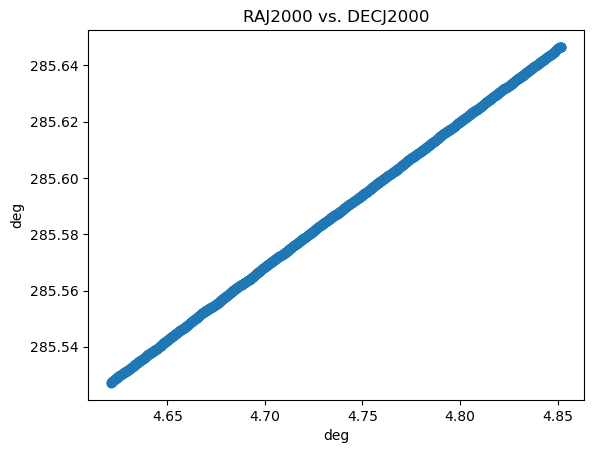

In [6]:
plot_one_file('/home/scratch/kwei/raw_data/AGBT13B_312_34/Antenna/2014_11_20_01:05:05.fits')

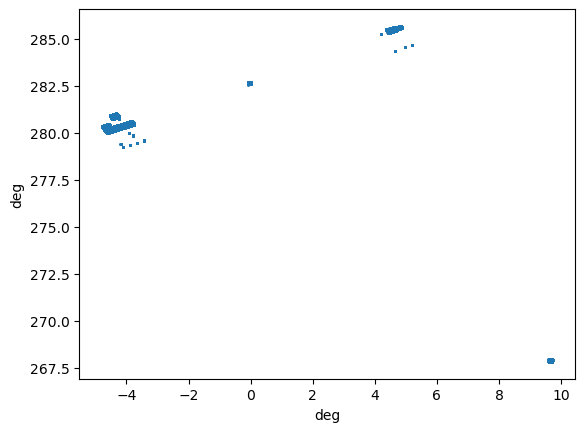

In [7]:
plot_all_files('/home/scratch/kwei/raw_data/AGBT13B_312_34/Antenna/')

In [ ]:
projection("/home/scratch/kwei/raw_data/AGBT13B_312_34/Antenna/")

In [8]:
expanded_projection("/home/scratch/tchamber/antenna_fits/")

  0%|                                                              | 2/20780 [00:00<18:25, 18.80it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:30:13.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:31:34.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:23:16.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:32:16.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:38:21.fits


  0%|                                                              | 8/20780 [00:00<17:37, 19.64it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:35:21.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:39:59.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:36:03.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:41:41.fits


  0%|                                                             | 13/20780 [00:00<17:01, 20.32it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:36:49.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:42:12.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:44:57.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:43:12.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:45:37.fits


  0%|                                                             | 16/20780 [00:00<17:14, 20.07it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:44:17.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:46:19.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:44:57.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:46:59.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:46:33.fits


  0%|                                                             | 22/20780 [00:01<17:30, 19.76it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:47:51.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:47:15.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_09:51:52.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:50:16.fits


  0%|                                                             | 25/20780 [00:01<17:13, 20.07it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_10:00:00.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:52:47.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_10:00:48.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:00:58.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_10:17:04.fits


  0%|                                                             | 31/20780 [00:01<17:08, 20.17it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:12:01.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_10:19:56.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:25:45.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_10:32:20.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:29:09.fits


  0%|                                                             | 37/20780 [00:01<17:11, 20.11it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_10:37:38.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:34:24.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:27:37.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:43:41.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:28:17.fits


  0%|                                                             | 40/20780 [00:01<17:03, 20.27it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:48:36.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:29:02.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:48:49.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:29:42.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_19:55:04.fits


  0%|▏                                                            | 46/20780 [00:02<17:05, 20.21it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:30:33.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_20:02:21.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:32:56.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_20:08:48.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:38:16.fits


  0%|▏                                                            | 52/20780 [00:02<16:46, 20.59it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:51:34.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:53:53.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_11:58:40.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_12:02:50.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_12:03:30.fits


  0%|▏                                                            | 55/20780 [00:02<16:57, 20.37it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_12:14:58.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:06:36.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:11:16.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:26:10.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:28:14.fits


  0%|▏                                                            | 61/20780 [00:03<16:40, 20.71it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:29:35.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:31:29.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:32:50.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:37:10.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:45:02.fits


  0%|▏                                                            | 64/20780 [00:03<17:08, 20.15it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_17:54:55.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:14:14.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:40:08.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:40:42.fits


  0%|▏                                                            | 70/20780 [00:03<17:06, 20.17it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:41:07.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_01/Antenna/2014_03_11_18:41:21.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:31:53.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:21:20.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:28:25.fits


  0%|▏                                                            | 73/20780 [00:03<17:07, 20.15it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:22:00.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:35:20.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:22:42.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:38:48.fits


  0%|▏                                                            | 79/20780 [00:03<17:15, 19.99it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:23:23.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:56:02.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:24:13.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:59:29.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:27:22.fits


  0%|▏                                                            | 85/20780 [00:04<17:11, 20.07it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:02:56.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:28:54.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:06:23.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:29:44.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:09:50.fits


  0%|▎                                                            | 88/20780 [00:04<17:27, 19.75it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:34:33.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:13:17.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:35:23.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:16:45.fits


  0%|▎                                                            | 93/20780 [00:04<17:32, 19.66it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:40:26.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:20:12.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:45:30.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:23:47.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:50:34.fits


  0%|▎                                                            | 97/20780 [00:04<17:47, 19.37it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:25:17.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_08:55:38.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:25:57.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:00:41.fits


  0%|▎                                                           | 102/20780 [00:05<17:25, 19.78it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:26:39.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:05:44.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:27:19.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:10:48.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:28:10.fits


  1%|▎                                                           | 107/20780 [00:05<17:23, 19.82it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:15:52.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:30:22.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:20:56.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:31:10.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:26:00.fits


  1%|▎                                                           | 113/20780 [00:05<16:46, 20.53it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:32:20.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:31:03.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:33:10.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:36:06.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:41:21.fits


  1%|▎                                                           | 116/20780 [00:05<17:31, 19.64it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:41:09.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:49:31.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:46:14.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_11:57:41.fits


  1%|▎                                                           | 120/20780 [00:06<18:54, 18.21it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:51:19.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:05:52.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:56:32.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:14:03.fits


  1%|▎                                                           | 124/20780 [00:06<18:51, 18.25it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:59:07.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:22:14.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_09:59:47.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:30:25.fits


  1%|▎                                                           | 129/20780 [00:06<17:56, 19.19it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:00:29.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:38:44.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:01:10.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:40:23.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:02:01.fits


  1%|▍                                                           | 133/20780 [00:06<17:27, 19.71it/s]

Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:41:05.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_10:05:00.fits
Loading /home/scratch/tchamber/antenna_fits/AGBT13B_312_02/Antenna/2014_03_16_12:41:48.fits


KeyboardInterrupt: 

 25%|████████████████▌                                                 | 1/4 [00:12<00:38, 12.82s/it]

['AGBT13B_312']


 50%|█████████████████████████████████                                 | 2/4 [00:21<00:20, 10.34s/it]

['AGBT13B_312']


100%|██████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.22s/it]

['AGBT13B_312', 'AGBT16A_353']
['AGBT13B_312', 'AGBT16A_353']


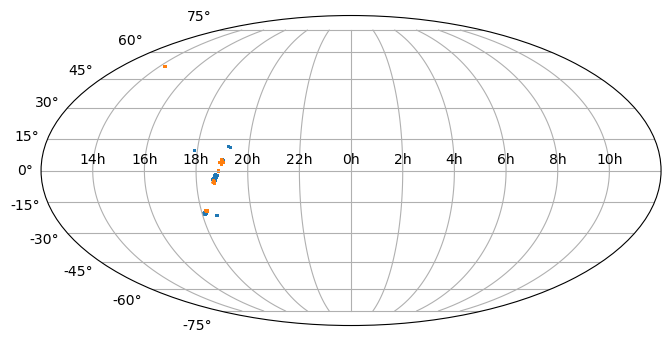

In [18]:
colored_projection_dict("/home/scratch/kwei/raw_data/")

100%|██████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.42s/it]


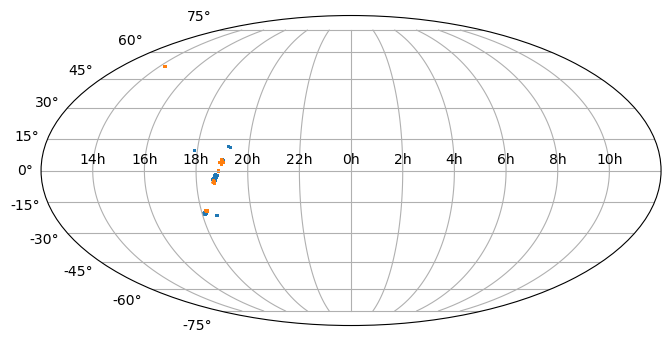

In [20]:
colored_projection_table("/home/scratch/kwei/raw_data/")

  1%|▎                                                               | 1/180 [00:03<09:57,  3.34s/it]

['AGBT13B_312']


  1%|▋                                                               | 2/180 [00:07<12:04,  4.07s/it]

['AGBT13B_312']


  2%|█                                                               | 3/180 [00:08<07:28,  2.53s/it]

['AGBT13B_312']


  2%|█▍                                                              | 4/180 [00:10<06:25,  2.19s/it]

['AGBT13B_312']


  3%|█▊                                                              | 5/180 [00:19<13:41,  4.69s/it]

['AGBT13B_312']


  3%|██▏                                                             | 6/180 [00:23<12:40,  4.37s/it]

['AGBT13B_312']


  4%|██▍                                                             | 7/180 [00:29<14:47,  5.13s/it]

['AGBT13B_312']


  4%|██▊                                                             | 8/180 [00:31<11:35,  4.04s/it]

['AGBT13B_312']


  5%|███▏                                                            | 9/180 [00:33<09:32,  3.35s/it]

['AGBT13B_312']


  6%|███▌                                                           | 10/180 [00:35<08:22,  2.96s/it]

['AGBT13B_312']


  6%|███▊                                                           | 11/180 [00:39<09:12,  3.27s/it]

['AGBT13B_312']


  7%|████▏                                                          | 12/180 [00:41<08:05,  2.89s/it]

['AGBT13B_312']


  7%|████▌                                                          | 13/180 [00:44<08:25,  3.02s/it]

['AGBT13B_312']


  8%|████▉                                                          | 14/180 [00:49<09:56,  3.59s/it]

['AGBT13B_312']


  8%|█████▎                                                         | 15/180 [00:51<08:12,  2.98s/it]

['AGBT13B_312']


  9%|█████▌                                                         | 16/180 [00:55<09:21,  3.42s/it]

['AGBT13B_312']


  9%|█████▉                                                         | 17/180 [01:02<11:50,  4.36s/it]

['AGBT13B_312']


 10%|██████▎                                                        | 18/180 [01:08<13:04,  4.84s/it]

['AGBT13B_312']


 11%|██████▋                                                        | 19/180 [01:14<13:48,  5.15s/it]

['AGBT13B_312']


 11%|███████                                                        | 20/180 [01:19<14:00,  5.25s/it]

['AGBT13B_312']


 12%|███████▎                                                       | 21/180 [01:25<14:24,  5.44s/it]

['AGBT13B_312']


 12%|███████▋                                                       | 22/180 [01:30<14:13,  5.40s/it]

['AGBT13B_312']


 13%|████████                                                       | 23/180 [01:32<11:16,  4.31s/it]

['AGBT13B_312']


 13%|████████▍                                                      | 24/180 [01:35<10:23,  4.00s/it]

['AGBT13B_312']


 14%|████████▊                                                      | 25/180 [01:44<13:45,  5.32s/it]

['AGBT13B_312']


 14%|█████████                                                      | 26/180 [01:48<13:00,  5.07s/it]

['AGBT13B_312']


 15%|█████████▍                                                     | 27/180 [01:54<13:44,  5.39s/it]

['AGBT13B_312']


 16%|█████████▊                                                     | 28/180 [01:59<12:55,  5.10s/it]

['AGBT13B_312']


 16%|██████████▏                                                    | 29/180 [02:11<18:24,  7.32s/it]

['AGBT13B_312']


 17%|██████████▌                                                    | 30/180 [02:15<15:52,  6.35s/it]

['AGBT13B_312']


 17%|██████████▊                                                    | 31/180 [02:22<15:54,  6.40s/it]

['AGBT13B_312']


 18%|███████████▏                                                   | 32/180 [02:26<14:26,  5.86s/it]

['AGBT13B_312']


 18%|███████████▌                                                   | 33/180 [02:34<15:18,  6.25s/it]

['AGBT13B_312']


 19%|███████████▉                                                   | 34/180 [02:46<19:55,  8.19s/it]

['AGBT13B_312']


 19%|████████████▎                                                  | 35/180 [02:56<21:03,  8.71s/it]

['AGBT13B_312']


 20%|████████████▌                                                  | 36/180 [03:01<18:09,  7.57s/it]

['AGBT13B_312']


 21%|████████████▉                                                  | 37/180 [03:06<15:52,  6.66s/it]

['AGBT13B_312']


 21%|█████████████▎                                                 | 38/180 [03:18<19:44,  8.34s/it]

['AGBT13B_312']


 22%|█████████████▋                                                 | 39/180 [03:24<17:51,  7.60s/it]

['AGBT13B_312']


 22%|██████████████                                                 | 40/180 [03:32<17:55,  7.68s/it]

['AGBT13B_312']


 23%|██████████████▎                                                | 41/180 [03:36<15:15,  6.59s/it]

['AGBT13B_312']


 23%|██████████████▋                                                | 42/180 [03:41<13:53,  6.04s/it]

['AGBT13B_312']


 24%|███████████████                                                | 43/180 [03:43<11:11,  4.91s/it]

['AGBT13B_312']


 24%|███████████████▍                                               | 44/180 [03:48<11:04,  4.89s/it]

['AGBT13B_312']


 25%|███████████████▊                                               | 45/180 [03:58<14:59,  6.66s/it]

['AGBT13B_312']


 26%|████████████████                                               | 46/180 [04:05<15:04,  6.75s/it]

['AGBT13B_312']


 26%|████████████████▍                                              | 47/180 [04:09<12:48,  5.78s/it]

['AGBT13B_312']


 27%|████████████████▊                                              | 48/180 [04:16<13:29,  6.13s/it]

['AGBT13B_312']


 27%|█████████████████▏                                             | 49/180 [04:21<12:46,  5.85s/it]

['AGBT13B_312']


 28%|█████████████████▌                                             | 50/180 [04:25<11:38,  5.37s/it]

['AGBT13B_312']


 28%|█████████████████▊                                             | 51/180 [04:36<14:40,  6.82s/it]

['AGBT13B_312']


 29%|██████████████████▏                                            | 52/180 [04:39<12:35,  5.90s/it]

['AGBT13B_312']


 29%|██████████████████▌                                            | 53/180 [04:43<11:14,  5.31s/it]

['AGBT13B_312']


 30%|██████████████████▉                                            | 54/180 [04:48<10:45,  5.12s/it]

['AGBT13B_312']


 31%|███████████████████▎                                           | 55/180 [04:56<12:19,  5.92s/it]

['AGBT13B_312']


 31%|███████████████████▌                                           | 56/180 [04:59<10:27,  5.06s/it]

['AGBT13B_312', 'AGBT15A_186']


 32%|███████████████████▉                                           | 57/180 [05:04<10:17,  5.02s/it]

['AGBT13B_312', 'AGBT15A_186']


 32%|████████████████████▎                                          | 58/180 [05:13<12:55,  6.35s/it]

['AGBT13B_312', 'AGBT15A_186']


 33%|████████████████████▋                                          | 59/180 [05:23<14:46,  7.33s/it]

['AGBT13B_312', 'AGBT15A_186']


 33%|█████████████████████                                          | 60/180 [05:25<11:34,  5.79s/it]

['AGBT13B_312', 'AGBT15A_186']


 34%|█████████████████████▎                                         | 61/180 [05:29<10:36,  5.35s/it]

['AGBT13B_312', 'AGBT15A_186']


 34%|█████████████████████▋                                         | 62/180 [05:36<11:12,  5.70s/it]

['AGBT13B_312', 'AGBT15A_186']


 35%|██████████████████████                                         | 63/180 [05:47<14:13,  7.30s/it]

['AGBT13B_312', 'AGBT15A_186']


 36%|██████████████████████▍                                        | 64/180 [05:55<14:53,  7.70s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 36%|██████████████████████▊                                        | 65/180 [06:06<16:13,  8.47s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 37%|███████████████████████                                        | 66/180 [06:12<14:36,  7.69s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 37%|███████████████████████▍                                       | 67/180 [06:20<14:46,  7.84s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 38%|███████████████████████▊                                       | 68/180 [06:31<16:17,  8.73s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 38%|████████████████████████▏                                      | 69/180 [06:41<16:54,  9.14s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 39%|████████████████████████▌                                      | 70/180 [06:44<13:40,  7.46s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 39%|████████████████████████▊                                      | 71/180 [06:50<12:51,  7.08s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 40%|█████████████████████████▏                                     | 72/180 [06:55<11:11,  6.21s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 41%|█████████████████████████▌                                     | 73/180 [06:59<10:19,  5.79s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 41%|█████████████████████████▉                                     | 74/180 [07:04<09:31,  5.39s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 42%|██████████████████████████▎                                    | 75/180 [07:10<09:34,  5.47s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 42%|██████████████████████████▌                                    | 76/180 [07:15<09:30,  5.49s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 43%|██████████████████████████▉                                    | 77/180 [07:24<11:00,  6.41s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 43%|███████████████████████████▎                                   | 78/180 [07:31<11:25,  6.72s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 44%|███████████████████████████▋                                   | 79/180 [07:36<10:16,  6.11s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 44%|████████████████████████████                                   | 80/180 [07:47<12:36,  7.57s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 45%|████████████████████████████▎                                  | 81/180 [07:49<10:04,  6.10s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 46%|████████████████████████████▋                                  | 82/180 [07:57<10:47,  6.61s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 46%|█████████████████████████████                                  | 83/180 [08:04<10:42,  6.63s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 47%|█████████████████████████████▍                                 | 84/180 [08:08<09:36,  6.00s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 47%|█████████████████████████████▊                                 | 85/180 [08:14<09:31,  6.02s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 48%|██████████████████████████████                                 | 86/180 [08:25<11:22,  7.26s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 48%|██████████████████████████████▍                                | 87/180 [08:29<09:54,  6.40s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 49%|██████████████████████████████▊                                | 88/180 [08:37<10:25,  6.80s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 49%|███████████████████████████████▏                               | 89/180 [08:45<10:47,  7.12s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 50%|███████████████████████████████▌                               | 90/180 [08:46<07:59,  5.33s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 51%|███████████████████████████████▊                               | 91/180 [08:52<08:13,  5.54s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 51%|████████████████████████████████▏                              | 92/180 [08:54<06:27,  4.41s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 52%|████████████████████████████████▌                              | 93/180 [08:59<06:53,  4.75s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 52%|████████████████████████████████▉                              | 94/180 [09:04<06:50,  4.78s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 53%|█████████████████████████████████▎                             | 95/180 [09:11<07:52,  5.56s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 53%|█████████████████████████████████▌                             | 96/180 [09:16<07:15,  5.18s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 54%|█████████████████████████████████▉                             | 97/180 [09:19<06:25,  4.64s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 54%|██████████████████████████████████▎                            | 98/180 [09:26<07:17,  5.33s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 55%|██████████████████████████████████▋                            | 99/180 [09:30<06:48,  5.05s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 56%|██████████████████████████████████▍                           | 100/180 [09:36<06:59,  5.24s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 56%|██████████████████████████████████▊                           | 101/180 [09:44<07:53,  6.00s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 57%|███████████████████████████████████▏                          | 102/180 [09:47<06:49,  5.25s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 57%|███████████████████████████████████▍                          | 103/180 [09:52<06:32,  5.10s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 58%|███████████████████████████████████▊                          | 104/180 [09:56<06:08,  4.85s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 58%|████████████████████████████████████▏                         | 105/180 [09:59<05:24,  4.33s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 59%|████████████████████████████████████▌                         | 106/180 [10:03<04:55,  4.00s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 59%|████████████████████████████████████▊                         | 107/180 [10:07<05:08,  4.22s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 60%|█████████████████████████████████████▏                        | 108/180 [10:12<05:08,  4.28s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 61%|█████████████████████████████████████▌                        | 109/180 [10:14<04:29,  3.79s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 61%|█████████████████████████████████████▉                        | 110/180 [10:17<04:04,  3.49s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 62%|██████████████████████████████████████▏                       | 111/180 [10:24<05:14,  4.56s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 62%|██████████████████████████████████████▌                       | 112/180 [10:34<06:50,  6.04s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 63%|██████████████████████████████████████▉                       | 113/180 [10:38<06:07,  5.49s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 63%|███████████████████████████████████████▎                      | 114/180 [10:46<06:52,  6.26s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 64%|███████████████████████████████████████▌                      | 115/180 [10:51<06:14,  5.77s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 64%|███████████████████████████████████████▉                      | 116/180 [10:58<06:38,  6.22s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 65%|████████████████████████████████████████▎                     | 117/180 [11:03<06:06,  5.82s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 66%|████████████████████████████████████████▋                     | 118/180 [11:08<05:54,  5.72s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 66%|████████████████████████████████████████▉                     | 119/180 [11:13<05:25,  5.34s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 67%|█████████████████████████████████████████▎                    | 120/180 [11:15<04:29,  4.48s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 67%|█████████████████████████████████████████▋                    | 121/180 [11:21<04:55,  5.01s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 68%|██████████████████████████████████████████                    | 122/180 [11:26<04:47,  4.96s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 68%|██████████████████████████████████████████▎                   | 123/180 [11:30<04:22,  4.60s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 69%|██████████████████████████████████████████▋                   | 124/180 [11:38<05:12,  5.59s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 69%|███████████████████████████████████████████                   | 125/180 [11:46<05:47,  6.32s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 70%|███████████████████████████████████████████▍                  | 126/180 [11:53<05:56,  6.61s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 71%|███████████████████████████████████████████▋                  | 127/180 [11:58<05:18,  6.01s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 71%|████████████████████████████████████████████                  | 128/180 [12:08<06:22,  7.36s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 72%|████████████████████████████████████████████▍                 | 129/180 [12:13<05:40,  6.67s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 72%|████████████████████████████████████████████▊                 | 130/180 [12:19<05:22,  6.45s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 73%|█████████████████████████████████████████████                 | 131/180 [12:26<05:17,  6.47s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 73%|█████████████████████████████████████████████▍                | 132/180 [12:34<05:31,  6.91s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 74%|█████████████████████████████████████████████▊                | 133/180 [12:40<05:20,  6.81s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 74%|██████████████████████████████████████████████▏               | 134/180 [12:45<04:45,  6.22s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 75%|██████████████████████████████████████████████▌               | 135/180 [12:51<04:37,  6.17s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 76%|██████████████████████████████████████████████▊               | 136/180 [12:56<04:08,  5.64s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 76%|███████████████████████████████████████████████▏              | 137/180 [12:59<03:26,  4.80s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 77%|███████████████████████████████████████████████▌              | 138/180 [13:01<02:53,  4.14s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 77%|███████████████████████████████████████████████▉              | 139/180 [13:06<03:03,  4.47s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 78%|████████████████████████████████████████████████▏             | 140/180 [13:11<02:57,  4.45s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 78%|████████████████████████████████████████████████▌             | 141/180 [13:16<02:57,  4.55s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 79%|████████████████████████████████████████████████▉             | 142/180 [13:19<02:41,  4.26s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 79%|█████████████████████████████████████████████████▎            | 143/180 [13:24<02:43,  4.41s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 80%|█████████████████████████████████████████████████▌            | 144/180 [13:30<02:53,  4.83s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 81%|█████████████████████████████████████████████████▉            | 145/180 [13:34<02:45,  4.73s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 81%|██████████████████████████████████████████████████▎           | 146/180 [13:41<02:57,  5.23s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 82%|██████████████████████████████████████████████████▋           | 147/180 [13:45<02:41,  4.89s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 82%|██████████████████████████████████████████████████▉           | 148/180 [13:53<03:04,  5.78s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 83%|███████████████████████████████████████████████████▎          | 149/180 [13:58<02:53,  5.59s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 83%|███████████████████████████████████████████████████▋          | 150/180 [14:07<03:16,  6.56s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 84%|████████████████████████████████████████████████████          | 151/180 [14:14<03:14,  6.72s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 84%|████████████████████████████████████████████████████▎         | 152/180 [14:20<03:04,  6.60s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 85%|████████████████████████████████████████████████████▋         | 153/180 [14:24<02:38,  5.89s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 86%|█████████████████████████████████████████████████████         | 154/180 [14:28<02:14,  5.18s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 86%|█████████████████████████████████████████████████████▍        | 155/180 [14:37<02:43,  6.53s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 87%|█████████████████████████████████████████████████████▋        | 156/180 [14:42<02:22,  5.94s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 87%|██████████████████████████████████████████████████████        | 157/180 [14:47<02:11,  5.70s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 88%|██████████████████████████████████████████████████████▍       | 158/180 [14:53<02:06,  5.73s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 88%|██████████████████████████████████████████████████████▊       | 159/180 [14:58<01:54,  5.44s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 89%|███████████████████████████████████████████████████████       | 160/180 [15:02<01:42,  5.11s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 89%|███████████████████████████████████████████████████████▍      | 161/180 [15:08<01:43,  5.46s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 90%|███████████████████████████████████████████████████████▊      | 162/180 [15:13<01:34,  5.23s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 91%|████████████████████████████████████████████████████████▏     | 163/180 [15:19<01:31,  5.37s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 91%|████████████████████████████████████████████████████████▍     | 164/180 [15:22<01:14,  4.66s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 92%|████████████████████████████████████████████████████████▊     | 165/180 [15:26<01:10,  4.67s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 92%|█████████████████████████████████████████████████████████▏    | 166/180 [15:37<01:29,  6.40s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 93%|█████████████████████████████████████████████████████████▌    | 167/180 [15:42<01:19,  6.08s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 93%|█████████████████████████████████████████████████████████▊    | 168/180 [15:48<01:10,  5.90s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 94%|██████████████████████████████████████████████████████████▏   | 169/180 [15:54<01:08,  6.18s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 94%|██████████████████████████████████████████████████████████▌   | 170/180 [16:00<01:00,  6.09s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 95%|██████████████████████████████████████████████████████████▉   | 171/180 [16:09<01:02,  6.90s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 96%|███████████████████████████████████████████████████████████▏  | 172/180 [16:16<00:55,  6.93s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 96%|███████████████████████████████████████████████████████████▌  | 173/180 [16:20<00:41,  5.88s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 97%|███████████████████████████████████████████████████████████▉  | 174/180 [16:28<00:40,  6.74s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 97%|████████████████████████████████████████████████████████████▎ | 175/180 [16:34<00:31,  6.27s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 98%|████████████████████████████████████████████████████████████▌ | 176/180 [16:38<00:23,  5.88s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


 98%|████████████████████████████████████████████████████████████▉ | 177/180 [16:42<00:15,  5.19s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


100%|██████████████████████████████████████████████████████████████| 180/180 [16:47<00:00,  5.59s/it]

['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']
['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']
['AGBT13B_312', 'AGBT15A_186', 'AGBT16A_353']


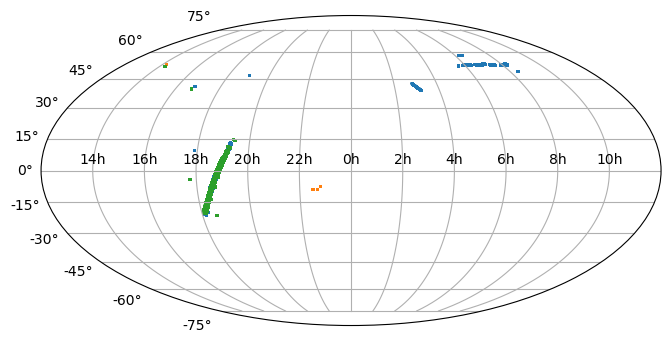

In [21]:
colored_projection_dict("/home/scratch/tchamber/antenna_fits/")

In [ ]:
colored_projection_table("/home/scratch/tchamber/antenna_fits/")

In [44]:
def separated_stack_tables_dict2(rootdir: str):
    """Returns a dictionary of RA, DEC data corresponding to different projects"""
    tables = {}
    paths = list(Path(rootdir).glob("*/Antenna/*.fits"))
    for path in tqdm(paths):
        split = str(path).split("/")[-3].split("_")
        project = "_".join(split[:-1])
        table = get_raj_decj_data(path)
        if project not in list(tables):
            tables[project] = [table]
        else:
            tables[project].append(table)
    for project in tables:
        tables[project] = vstack(tables[project])
    return tables

def colored_projection_dict2(directory: str):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    tables = separated_stack_tables_dict2(directory)
    for project in tables:
        ra = coord.Angle(tables[project]["RAJ2000"])
        ra = ra.wrap_at(180 * u.degree)
        dec = coord.Angle(tables[project]["DECJ2000"])
        ax.scatter(ra.radian, dec.radian, s=0.5)
    ax.set_xticklabels(
        ["14h", "16h", "18h", "20h", "22h", "0h", "2h", "4h", "6h", "8h", "10h"]
    )
    ax.grid(True)
    fig.show()

def separated_stack_tables_table2(rootdir: str):
    """Returns a table of RA, DEC, project name data"""
    stacked_table = []
    projects = []
    paths = list(Path(rootdir).glob("*/Antenna/*.fits"))
    for path in tqdm(paths):
        project_match = re.match(r"[a-zA-Z0-9]+[_][\d]+[_]", str(subdir))
        if not project_match:
            raise ValueError("File does not match naming format")
        else:
            project = project_match.group(0)[:-1]
        table = Table.read(path, hdu=2)
        formatted_table = hstack(
            [
                table["RAJ2000"],
                table["DECJ2000"],
                Column(name="Project", data=np.full(len(table), project)),
            ]
        )
        stacked_table.append(formatted_table)
        if project not in projects:
            projects.append(project)
    return vstack(stacked_table), projects

def colored_projection_table2(directory: str):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="mollweide")
    table, projects = separated_stack_tables_table2(directory)
    for project in projects:
        sliced = table[table["Project"] == project]
        ra = coord.Angle(sliced["RAJ2000"])
        ra = ra.wrap_at(180 * u.degree)
        dec = coord.Angle(sliced["DECJ2000"])
        ax.scatter(ra.radian, dec.radian, s=0.5)
    ax.set_xticklabels(
        ["14h", "16h", "18h", "20h", "22h", "0h", "2h", "4h", "6h", "8h", "10h"]
    )
    ax.grid(True)
    fig.show()

100%|██████████████████████████████████████████████████████████████| 598/598 [00:29<00:00, 20.50it/s]


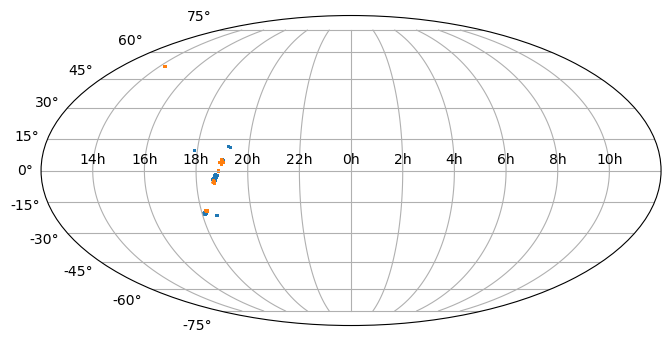

In [41]:
colored_projection_dict2("/home/scratch/kwei/raw_data/")

100%|██████████████████████████████████████████████████████████████| 598/598 [00:29<00:00, 20.35it/s]


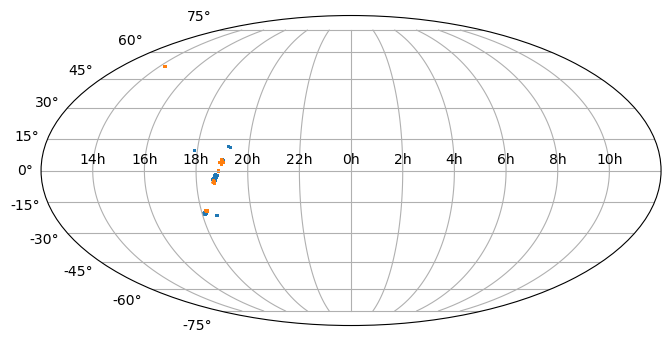

In [45]:
colored_projection_table2("/home/scratch/kwei/raw_data/")

100%|██████████████████████████████████████████████████████████| 20780/20780 [16:32<00:00, 20.94it/s]


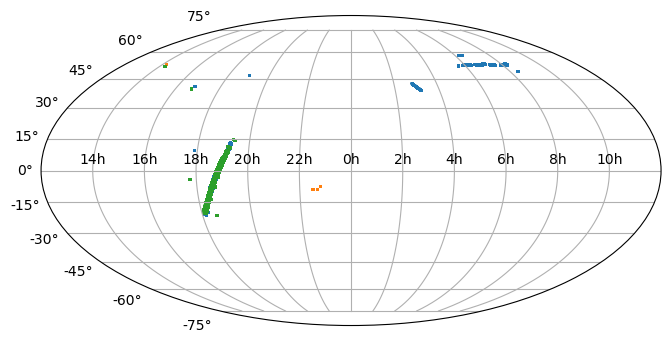

In [46]:
colored_projection_dict2("/home/scratch/tchamber/antenna_fits/")

100%|██████████████████████████████████████████████████████████| 20780/20780 [17:06<00:00, 20.25it/s]


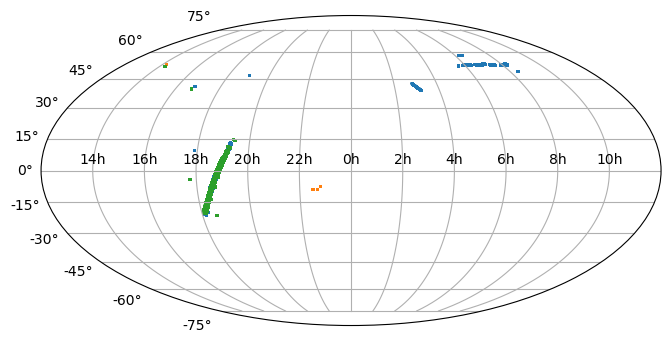

In [47]:
colored_projection_table2("/home/scratch/tchamber/antenna_fits/")